In [1]:
!pip install torchview
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.5 MB/s eta 0:00:00


# **Sexist Classification with BERT Embeddings using Multi-task Convolutional Neural Network**

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchview import draw_graph
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import Adam
from torcheval.metrics import MulticlassF1Score
from sklearn.metrics import classification_report
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

import os
datadir = '/kaggle/input/data_6'
# datadir = '../data_6'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEVELS = np.array(['1', '2', '3', '3_1', '3_2', '3_3', '3_4'])
BATCH_SIZE = 24

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Load Data**

In [3]:
train = pd.read_csv(os.path.join(datadir, 'train.csv'))
dev = pd.read_csv(os.path.join(datadir, 'dev.csv'))
test = pd.read_csv(os.path.join(datadir, 'test.csv'))

train.head()

,rewire_id,text,label_1,label_2,label_3,label_3_1,label_3_2,label_3_3,label_3_4,tokens
0,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,"then , she's a keeper . :winking_face:"
1,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,this is like the metallica video where the poo...
2,sexism2022_english-13021,woman?,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,woman ?
3,sexism2022_english-14998,Unlicensed day care worker reportedly tells co...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,unlicensed day care worker reportedly tells co...
4,sexism2022_english-7228,[USER] Leg day is easy. Hot girls who wear min...,sexist,3. animosity,3.3 backhanded gendered compliments,other,other,3.3 backhanded gendered compliments,other,user leg day is easy . hot girls who wear mini...


In [4]:
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
dev = dev.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

train.head()

,rewire_id,text,label_1,label_2,label_3,label_3_1,label_3_2,label_3_3,label_3_4,tokens
0,sexism2022_english-10017,She'll get a nice divorce settlement. Tiger Wo...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,she'll get a nice divorce settlement . tiger w...
1,sexism2022_english-10571,[URL] Here is another thread on it. I think it...,sexist,3. animosity,3.2 immutable gender differences and gender st...,other,other,3.2 immutable gender differences and gender st...,other,url here is another thread on it . i think its...
2,sexism2022_english-3800,one girl that I went to high school with liter...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,one girl that i went to high school with liter...
3,sexism2022_english-10977,Or change her name to a more fact base one lik...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,or change her name to a more fact base one lik...
4,sexism2022_english-8905,flat chested girls are little brothers to guys,sexist,2. derogation,2.1 descriptive attacks,other,2.1 descriptive attacks,other,other,flat chested girls are little brothers to guys


### Labels to categories

In [5]:
ALL_LABELS = []
for i in range(len(LEVELS)):
    ALL_LABELS.append(np.array(sorted(train[f'label_{LEVELS[i]}'].unique().tolist())))
ALL_LABELS = np.array(ALL_LABELS, dtype=object)
ALL_LABELS

array([array(['not sexist', 'sexist'], dtype='<U10'),
       array(['1. threats, plans to harm and incitement', '2. derogation',
              '3. animosity', '4. prejudiced discussions', 'not sexist'],
             dtype='<U40')                                                ,
       array(['1.1 threats of harm', '1.2 incitement and encouragement of harm',
              '2.1 descriptive attacks', '2.2 aggressive and emotive attacks',
              '2.3 dehumanising attacks & overt sexual objectification',
              '3.1 casual use of gendered slurs, profanities, and insults',
              '3.2 immutable gender differences and gender stereotypes',
              '3.3 backhanded gendered compliments',
              '3.4 condescending explanations or unwelcome advice',
              '4.1 supporting mistreatment of individual women',
              '4.2 supporting systemic discrimination against women as a group',
              'not sexist'], dtype='<U63')                              

In [6]:
def label_to_idx(label, level):
    return ALL_LABELS[level-1].tolist().index(label)

def idx_to_label(idx, level):
    return ALL_LABELS[level-1][idx]

label_to_idx('not sexist', 5), idx_to_label(2, 3)

(3, '2.1 descriptive attacks')

In [7]:
y_trains = torch.empty((len(train), len(LEVELS)), dtype=torch.long)
y_devs = torch.empty((len(dev), len(LEVELS)), dtype=torch.long)
y_tests = torch.empty((len(test), len(LEVELS)), dtype=torch.long)

for i in range(len(LEVELS)):
    y_trains[:, i] = torch.tensor(train[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)).values, dtype=torch.long)
    y_devs[:, i] = torch.tensor(dev[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)).values, dtype=torch.long)
    y_tests[:, i] = torch.tensor(test[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)).values, dtype=torch.long)

y_trains.shape, y_devs.shape, y_tests.shape

(torch.Size([14000, 7]), torch.Size([2000, 7]), torch.Size([4000, 7]))

### Class weights

In [8]:
classes_weights = []
for i in range(len(LEVELS)):
    w = 1 / torch.bincount(y_trains[:, i]).float()
    w = w / w.sum()
    classes_weights.append(w.to(device))
classes_weights

[tensor([0.2427, 0.7573], device='cuda:0'),
 tensor([0.4130, 0.0805, 0.1099, 0.3845, 0.0121], device='cuda:0'),
 tensor([0.2033, 0.0448, 0.0159, 0.0169, 0.0569, 0.0179, 0.0273, 0.1779, 0.2422,
         0.1518, 0.0441, 0.0011], device='cuda:0'),
 tensor([0.8039, 0.1772, 0.0042, 0.0146], device='cuda:0'),
 tensor([0.1635, 0.1742, 0.5863, 0.0111, 0.0649], device='cuda:0'),
 tensor([0.0379, 0.0579, 0.3773, 0.5138, 0.0023, 0.0108], device='cuda:0'),
 tensor([0.7563, 0.2199, 0.0054, 0.0185], device='cuda:0')]

## **BERT Embeddings**

In [9]:
# model_path = 'distilbert-base-uncased' # cpu
model_path = 'roberta-base' # gpu

tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_model = AutoModel.from_pretrained(model_path)

model_name = model_path.split('/')[-1]
assert len(model_name.split('/')) == 1

model_name

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'roberta-base'

### Padding by batch Dataset

In [10]:
class MiniBatchPaddingDataset(Dataset):
    def __init__(self, x, y, batch_size=BATCH_SIZE):
        self.y = y
        self.batch_size = batch_size

        # padding by max length in each batch
        self.num_batches = math.ceil(len(x) / self.batch_size)

        self.input_ids = []
        self.attention_masks = []
        
        for batch in range(self.num_batches):
            batch_start = batch * self.batch_size
            batch_end = min((batch + 1) * self.batch_size, len(x))

            batch_encodings = tokenizer(x[batch_start:batch_end], 
                                        padding=True, 
                                        max_length=120,
                                        truncation=True)
            batch_input_ids = batch_encodings['input_ids']
            batch_attention_mask = batch_encodings['attention_mask']

            self.input_ids += batch_input_ids
            self.attention_masks += batch_attention_mask
            

    def __getitem__(self, index):
        input_ids = torch.tensor(self.input_ids[index])
        attention_mask = torch.tensor(self.attention_masks[index])
        labels = torch.tensor(self.y[index])
        inputs = torch.stack((input_ids, attention_mask))

        return inputs, labels
    
    def __len__(self):
        return len(self.input_ids)

In [11]:
x_trains = train['text'].tolist()
x_devs = dev['text'].tolist()
x_tests = test['text'].tolist()

train_dataset = MiniBatchPaddingDataset(x_trains, y_trains)
dev_dataset = MiniBatchPaddingDataset(x_devs, y_devs)
test_dataset = MiniBatchPaddingDataset(x_tests, y_tests)

### Dataloader

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
for inputs, labels in train_loader:
    print(inputs.shape)
    print(labels.shape)

    break

torch.Size([24, 2, 61])
torch.Size([24, 7])


In [14]:
bert_model(inputs[:, 0, :], inputs[:, 1, :])['last_hidden_state'].shape

torch.Size([24, 61, 768])

### Embedding Layer

In [15]:
class BERT_Embedding(torch.nn.Module):
    def __init__(self, model):
        super(BERT_Embedding, self).__init__()
        self.bert_model = model

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids
        attention_mask = attention_mask

        # inputs shape: (batch_size, max_seq_len)
        # outputs shape: (batch_size, max_seq_len, embedding_size)
        outputs = self.bert_model(input_ids, attention_mask)
        outputs = outputs['last_hidden_state']
        # print('bert embedding outputs:', outputs.shape)
        return outputs
    
    def __getitem__(self):
        return self.bert_model
        
    def get_embedding_size(self):
        return self.bert_model.config.hidden_size
    
    def get_embedding_dim(self):
        return self.bert_model.config.hidden_size


## **Model**

### **MultiConvos**

In [16]:
# multi convos layer
class MultiConvos(nn.Module):

    class GlobalMaxPool1d(nn.Module):
        def __init__(self):
            super(MultiConvos.GlobalMaxPool1d, self).__init__()

        def forward(self, inputs):
            return torch.max(inputs, dim=-1)[0]
       
    class ConcatTensor(nn.Module):
        def __init__(self):
            super(MultiConvos.ConcatTensor, self).__init__()

        def forward(self, inputs):
            return torch.cat(inputs, dim=1)

    
    def __init__(self, configs=None, dropout_concat=0, input_dim=None, **kwargs):
        super(MultiConvos, self).__init__(**kwargs)

        if input_dim is None:
            Exception('Please specify input_dim')

        if configs is None:
            self.configs = {3: {'filters': 32, 'dropout': 0.25},
                            4: {'filters': 32, 'dropout': 0.25},
                            5: {'filters': 32, 'dropout': 0.25}}
        else:
            self.configs = configs
            
        self.convs = nn.ModuleList()  # Use nn.ModuleList instead of a regular list
        for key in self.configs:
            # input shape: (batch_size, embedding_size, max_seq_len)
            # output shape: (batch_size, filters, max_seq_len)
            conv = nn.Conv1d(in_channels=input_dim, 
                             out_channels=int(self.configs[key]['filters']), 
                             kernel_size=int(key))
            nn.init.kaiming_normal_(conv.weight)
            if float(self.configs[key]['dropout']) > 0:
                dropout = nn.Dropout(p=float(self.configs[key]['dropout']))
            else:
                dropout = None

            # input shape: (batch_size, filters, max_seq_len)
            # output shape: (batch_size, filters)
            pool = MultiConvos.GlobalMaxPool1d()
            self.convs.append(nn.Sequential(conv, nn.ReLU(), dropout, pool))  # Apply activation function separately
#             self.convs.append(nn.Sequential(conv, dropout, pool))  # Apply activation function separately

        # self.concat = nn.Concatenate(dim=1)
        if dropout_concat > 0:
            self.dropout_concat = nn.Dropout(p=dropout_concat)
        else:
            self.dropout_concat = None

    def forward(self, inputs: torch.Tensor):
        # transpose to (batch_size, embedding_size, max_seq_len)
        # inputs = inputs.transpose(1, 2)
        inputs = inputs.permute(0, 2, 1)
        # print(inputs.shape)
        convs = []
        for i, key in enumerate(self.configs):
            # convolutional layer
            conv = self.convs[i][0](inputs)
            # activation function: ReLU
            conv = self.convs[i][1](conv)
            if self.convs[i][2] is not None:
                conv = self.convs[i][2](conv)
            # global max pooling
            conv = self.convs[i][3](conv)
#             print(conv.shape)
            convs.append(conv)
        # concat all convs
        concat = MultiConvos.ConcatTensor()(convs)
        if self.dropout_concat is not None:
            concat = self.dropout_concat(concat)
        return concat
    
    def __output_dim__(self):
        return sum([self.configs[key]['filters'] for key in self.configs])

### **Model**

In [17]:
class MultiTask_CNN_Model(nn.Module):
    def __init__(self, 
                 convo_configs=None, 
                 dropout_concat=0.1, 
                 dense_dim=128,
                 dropout_embedding=0.1,
                **kwargs):
        super(MultiTask_CNN_Model, self).__init__(**kwargs)
        
        self.bert_embedding = BERT_Embedding(bert_model)
        self.embedding_dropout = nn.Dropout(dropout_embedding)
        self.multi_convos = MultiConvos(convo_configs, 
                                        dropout_concat=dropout_concat,
                                        input_dim=self.bert_embedding.get_embedding_dim())
        self.denses = nn.ModuleList()
        self.FCs = nn.ModuleList()
        dense_input_size = self.multi_convos.__output_dim__()

        for i in range(0, len(LEVELS)):
            self.denses.append(nn.Sequential(nn.Linear(dense_input_size, dense_dim), 
                                             nn.ReLU(), nn.Dropout(0.2)))
#             self.FCs.append(nn.Sequential(nn.Linear(dense_dim, ALL_LABELS[i].shape[0]), 
#                                           nn.Softmax(dim=1)))
            self.FCs.append(nn.Linear(dense_dim, ALL_LABELS[i].shape[0]))
#             self.FCs.append(nn.Linear(dense_input_size, ALL_LABELS[i].shape[0]))

    def forward(self, inputs):
        bert_embedding = self.bert_embedding(inputs[:, 0, :], inputs[:, 1, :])
        bert_embedding = self.embedding_dropout(bert_embedding)
        multi_convos = self.multi_convos(bert_embedding)
#         print(multi_convos[:, 0])
        # print(multi_convos.shape)
        denses = []
        for i in range(0, len(LEVELS)):
            denses.append(self.denses[i](multi_convos))
        logits = []
        for i in range(0, len(LEVELS)):
            logits.append(self.FCs[i](denses[i]))
#             logits.append(self.FCs[i](multi_convos))
#         print(logits[0])
        return logits

## **Training**

### Losses and Metrics

In [18]:
def loss_fn(logits, labels, classes_weights, task_weights=None):
    # print(labels.shape)
    # losses = multi_task_loss(logits, labels).to(device)
    losses = torch.zeros(len(LEVELS)).to(device)
    for i in range(len(LEVELS)):
        # print(logits[i].shape, labels[:, i].shape, classes_weights[i].shape)
        losses[i] = nn.functional.cross_entropy(logits[i], labels[:, i], 
                                                weight=classes_weights[i])
#         print(losses[i])
    if task_weights is None:
        loss = losses.sum()
    else:
        loss = (losses * task_weights).sum()
#     print(loss)

    return loss, losses

In [19]:
def multi_task_metrics_batch(logits_batch, labels_batch):
    batch_f1s = []
    metrics = [MulticlassF1Score(num_classes=ALL_LABELS[i].shape[0], average='macro', device=device) for i in range(len(LEVELS))]
    # calculate f1 score for each level by batch
    for i in range(len(LEVELS)):
        metrics[i].update(logits_batch[i], labels_batch[:, i])
        batch_f1s.append(metrics[i].compute())
    return batch_f1s

### Training and Evaluation

In [20]:
def train_epoch(model, loader, optimizer, device, classes_weights, task_weights):
    model.train()
    joint_losses = []
    multi_losses = []
    multi_f1s = []

    for batch in tqdm(loader):        
        logits = model(batch[0].to(device))
        labels = batch[1].to(device)
        joint_loss, multitask_losses = loss_fn(logits, labels, classes_weights, task_weights)
        
        joint_losses.append(joint_loss.item())
        multi_losses.append(multitask_losses)

        joint_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        f1s = multi_task_metrics_batch(logits, labels)
        multi_f1s.append(f1s)

    epoch_joint_loss = torch.mean(torch.tensor(joint_losses))

    epoch_multi_losses = []
    epoch_multi_f1s = []
    for i in range(len(LEVELS)):
        epoch_multi_losses.append(torch.mean(torch.tensor([loss[i].item() for loss in multi_losses])))
        epoch_multi_f1s.append(torch.mean(torch.tensor([f1[i] for f1 in multi_f1s])))

    return epoch_joint_loss, epoch_multi_losses, epoch_multi_f1s

In [21]:
def eval_epoch(model, loader, device, classes_weights, task_weights):
    model.eval()
    joint_losses = []
    multi_losses = []
    multi_f1s = []
    
    with torch.no_grad():
        for batch in tqdm(loader):
            logits = model(batch[0].to(device))
            labels = batch[1].to(device)
            joint_loss, multitask_losses = loss_fn(logits, labels, classes_weights, task_weights)
            
            joint_losses.append(joint_loss.item())
            multi_losses.append(multitask_losses)

            f1s = multi_task_metrics_batch(logits, labels)
            multi_f1s.append(f1s)
                        
    epoch_loss = torch.mean(torch.tensor(joint_losses), dim=0)
    epoch_multi_losses = []
    epoch_multi_f1s = []
    for i in range(len(LEVELS)):
        epoch_multi_losses.append(torch.mean(torch.tensor([loss[i].item() for loss in multi_losses])))
        epoch_multi_f1s.append(torch.mean(torch.tensor([f1[i] for f1 in multi_f1s])))

    return epoch_loss, epoch_multi_losses, epoch_multi_f1s

In [22]:
def train_and_validate(model, train_loader, dev_loader, optimizer, device, classes_weights, epochs=3, task_weights=None):
    train_losses = []
    train_multi_losses = []
    train_f1s = []
    dev_losses = []
    dev_multi_losses = []
    dev_f1s = []
    optimizer.zero_grad()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}')
        train_loss, train_multi_loss, train_f1 = train_epoch(model, train_loader, optimizer, device, classes_weights, task_weights)
        train_losses.append(train_loss)
        print(f'Train loss: {train_losses[-1]:.6f}')

        train_multi_losses.append(train_multi_loss)
        train_f1s.append(train_f1)
        for i in range(len(LEVELS)):
            print(f'> Level {LEVELS[i]}: loss {train_multi_losses[-1][i]:.5f}')
        
        dev_loss, dev_multi_loss, dev_f1 = eval_epoch(model, dev_loader, device, classes_weights, task_weights)
        dev_losses.append(dev_loss)
        print(f'Dev loss: {dev_losses[-1]:.5f}')

        dev_multi_losses.append(dev_multi_loss)
        dev_f1s.append(dev_f1)
        for i in range(len(LEVELS)):
            print(f'> Level {LEVELS[i]}: loss {dev_multi_losses[-1][i]:.5f}')
            
        print('=================== \n')
    
    return train_losses, train_multi_losses, train_f1s, dev_losses, dev_multi_losses, dev_f1s

### Config

In [23]:
print('device:', device)

multi_convos_config = {
    1: {'filters': 256, 'dropout': 0.5},
    2: {'filters': 512, 'dropout': 0.5},
    3: {'filters': 512, 'dropout': 0.5},
    4: {'filters': 256, 'dropout': 0.5},
    5: {'filters': 128, 'dropout': 0.5},
    6: {'filters': 64, 'dropout': 0.5}
}
    
model = MultiTask_CNN_Model(multi_convos_config, 
                            dense_dim=768, 
                            dropout_concat=0.5,
                            dropout_embedding=0.5)
model.to(device)
# print(model)

optimizer = Adam(model.parameters(), lr=2.5e-6, weight_decay=1e-8)

task_weights = torch.tensor([1.0, 1.5, 2.0, 2.0, 2.0, 2.0, 2.0]).to(device)

device: cuda


### **Visualize Model**

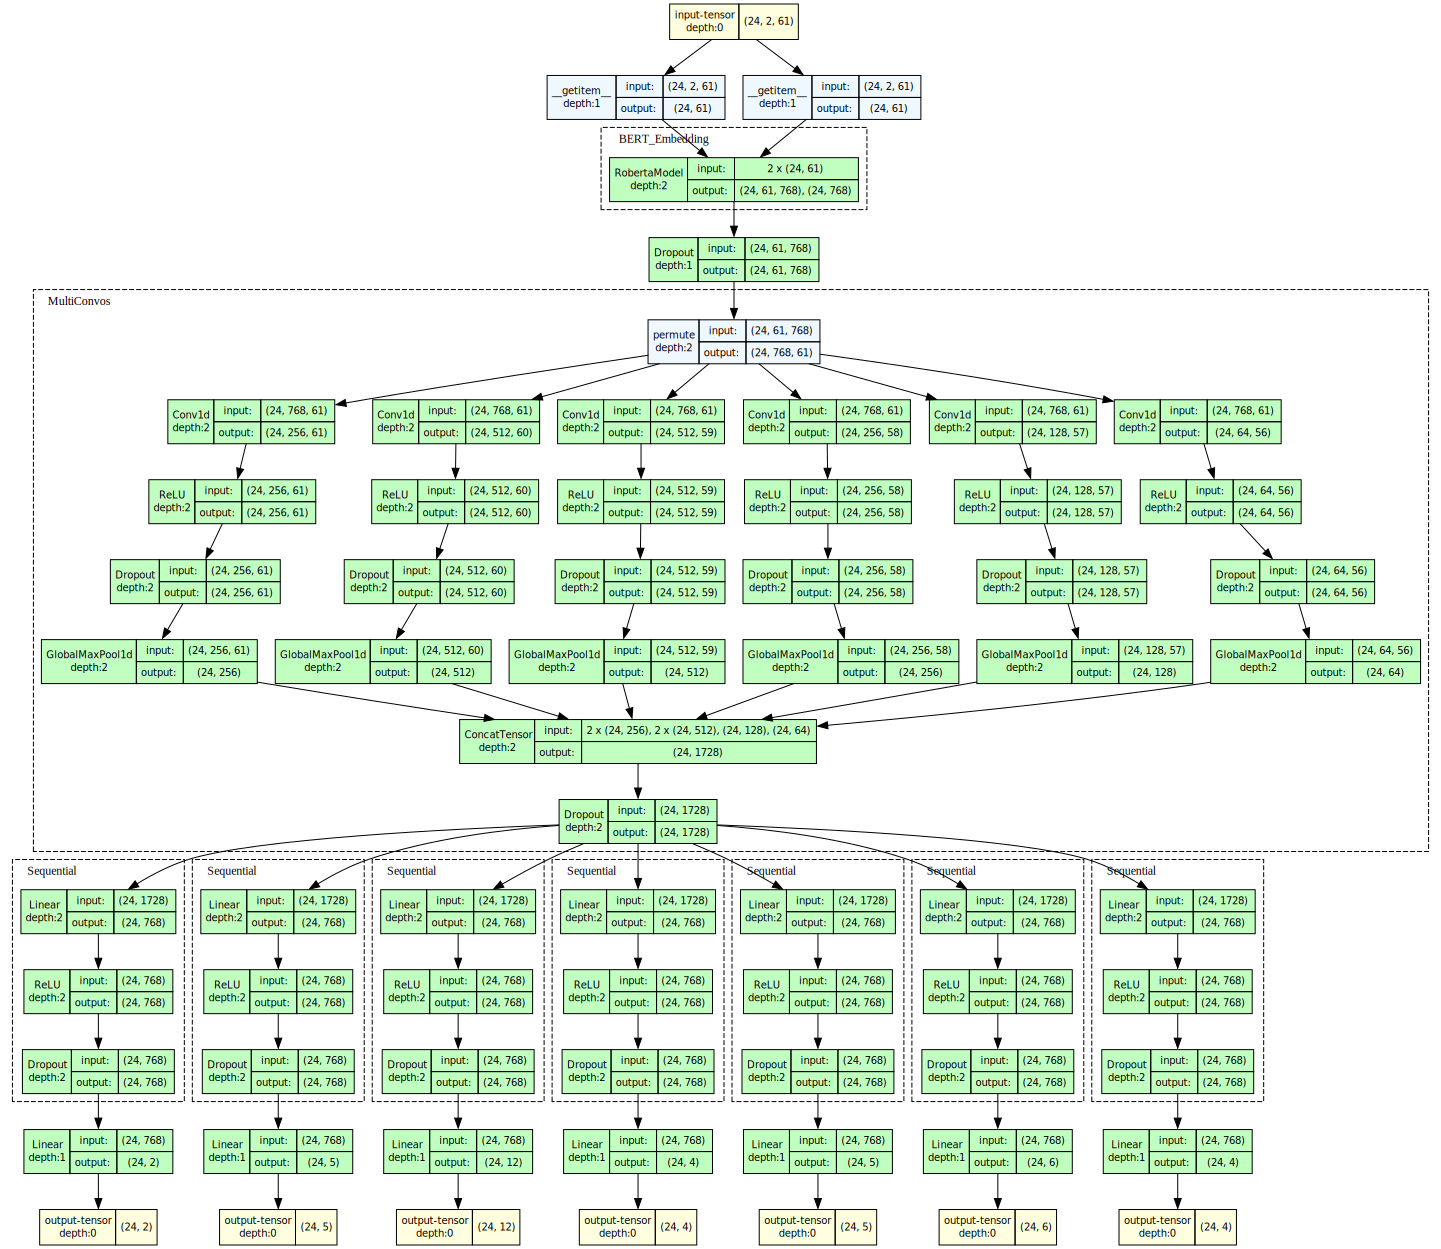

In [24]:
model_graph = draw_graph(model, 
                         input_data=(inputs),
                         expand_nested=True,
                         depth=2,
                         graph_name='MultiTask_CNN_Model',
                         save_graph=True)
model_graph.visual_graph

### Start training

In [25]:
EPOCHS = 35

train_losses, train_multi_losses, train_f1s, dev_losses, dev_multi_losses, dev_f1s = train_and_validate(model, 
                                                                                                        train_loader, dev_loader,
                                                                                                        optimizer, device, 
                                                                                                        classes_weights=classes_weights,
                                                                                                        epochs=EPOCHS,
                                                                                                        task_weights=task_weights)

Epoch 1


100%|██████████| 584/584 [01:43<00:00,  5.63it/s]


Train loss: 24.012878
> Level 1: loss 0.86918
> Level 2: loss 1.97558
> Level 3: loss 2.89813
> Level 3_1: loss 1.54370
> Level 3_2: loss 1.95430
> Level 3_3: loss 2.11533
> Level 3_4: loss 1.57871


100%|██████████| 84/84 [00:04<00:00, 17.20it/s]


Dev loss: 20.17848
> Level 1: loss 0.69291
> Level 2: loss 1.60757
> Level 3: loss 2.47617
> Level 3_1: loss 1.35125
> Level 3_2: loss 1.60072
> Level 3_3: loss 1.75518
> Level 3_4: loss 1.35379

Epoch 2


100%|██████████| 584/584 [01:42<00:00,  5.68it/s]


Train loss: 22.395962
> Level 1: loss 0.81415
> Level 2: loss 1.82152
> Level 3: loss 2.72532
> Level 3_1: loss 1.46389
> Level 3_2: loss 1.87585
> Level 3_3: loss 1.89116
> Level 3_4: loss 1.46854


100%|██████████| 84/84 [00:04<00:00, 17.45it/s]


Dev loss: 20.17698
> Level 1: loss 0.69192
> Level 2: loss 1.60383
> Level 3: loss 2.47515
> Level 3_1: loss 1.36163
> Level 3_2: loss 1.60187
> Level 3_3: loss 1.75366
> Level 3_4: loss 1.34734

Epoch 3


100%|██████████| 584/584 [01:42<00:00,  5.68it/s]


Train loss: 20.899746
> Level 1: loss 0.74901
> Level 2: loss 1.72532
> Level 3: loss 2.58761
> Level 3_1: loss 1.33753
> Level 3_2: loss 1.72476
> Level 3_3: loss 1.77475
> Level 3_4: loss 1.35673


100%|██████████| 84/84 [00:04<00:00, 17.39it/s]


Dev loss: 20.00466
> Level 1: loss 0.67356
> Level 2: loss 1.58947
> Level 3: loss 2.44883
> Level 3_1: loss 1.34913
> Level 3_2: loss 1.58537
> Level 3_3: loss 1.74049
> Level 3_4: loss 1.34963

Epoch 4


100%|██████████| 584/584 [01:42<00:00,  5.69it/s]


Train loss: 18.823767
> Level 1: loss 0.61277
> Level 2: loss 1.56813
> Level 3: loss 2.42137
> Level 3_1: loss 1.16376
> Level 3_2: loss 1.55238
> Level 3_3: loss 1.58948
> Level 3_4: loss 1.20241


100%|██████████| 84/84 [00:04<00:00, 17.34it/s]


Dev loss: 19.02275
> Level 1: loss 0.59740
> Level 2: loss 1.52532
> Level 3: loss 2.38646
> Level 3_1: loss 1.26102
> Level 3_2: loss 1.50784
> Level 3_3: loss 1.65113
> Level 3_4: loss 1.26222

Epoch 5


100%|██████████| 584/584 [01:42<00:00,  5.69it/s]


Train loss: 16.563353
> Level 1: loss 0.48671
> Level 2: loss 1.37220
> Level 3: loss 2.22329
> Level 3_1: loss 0.98928
> Level 3_2: loss 1.41251
> Level 3_3: loss 1.36846
> Level 3_4: loss 1.01564


100%|██████████| 84/84 [00:04<00:00, 17.33it/s]


Dev loss: 18.04388
> Level 1: loss 0.53812
> Level 2: loss 1.44583
> Level 3: loss 2.30785
> Level 3_1: loss 1.17786
> Level 3_2: loss 1.44470
> Level 3_3: loss 1.55603
> Level 3_4: loss 1.18206

Epoch 6


100%|██████████| 584/584 [01:42<00:00,  5.68it/s]


Train loss: 15.065052
> Level 1: loss 0.43899
> Level 2: loss 1.21389
> Level 3: loss 2.04896
> Level 3_1: loss 0.87501
> Level 3_2: loss 1.32661
> Level 3_3: loss 1.27674
> Level 3_4: loss 0.87529


100%|██████████| 84/84 [00:04<00:00, 17.31it/s]


Dev loss: 17.34056
> Level 1: loss 0.50992
> Level 2: loss 1.37439
> Level 3: loss 2.23960
> Level 3_1: loss 1.10919
> Level 3_2: loss 1.40527
> Level 3_3: loss 1.50916
> Level 3_4: loss 1.12130

Epoch 7


100%|██████████| 584/584 [01:42<00:00,  5.69it/s]


Train loss: 13.888177
> Level 1: loss 0.38972
> Level 2: loss 1.09276
> Level 3: loss 1.88664
> Level 3_1: loss 0.78697
> Level 3_2: loss 1.26523
> Level 3_3: loss 1.20432
> Level 3_4: loss 0.78650


100%|██████████| 84/84 [00:04<00:00, 17.33it/s]


Dev loss: 16.61335
> Level 1: loss 0.47410
> Level 2: loss 1.30346
> Level 3: loss 2.17629
> Level 3_1: loss 1.04695
> Level 3_2: loss 1.36640
> Level 3_3: loss 1.44899
> Level 3_4: loss 1.05339

Epoch 8


100%|██████████| 584/584 [01:42<00:00,  5.68it/s]


Train loss: 13.181843
> Level 1: loss 0.37045
> Level 2: loss 1.02302
> Level 3: loss 1.78998
> Level 3_1: loss 0.72051
> Level 3_2: loss 1.22648
> Level 3_3: loss 1.17064
> Level 3_4: loss 0.73082


100%|██████████| 84/84 [00:04<00:00, 17.17it/s]


Dev loss: 16.36800
> Level 1: loss 0.47194
> Level 2: loss 1.28038
> Level 3: loss 2.14844
> Level 3_1: loss 1.02093
> Level 3_2: loss 1.35124
> Level 3_3: loss 1.43397
> Level 3_4: loss 1.03316

Epoch 9


100%|██████████| 584/584 [01:42<00:00,  5.68it/s]


Train loss: 12.172159
> Level 1: loss 0.33800
> Level 2: loss 0.91328
> Level 3: loss 1.66611
> Level 3_1: loss 0.65332
> Level 3_2: loss 1.17665
> Level 3_3: loss 1.09377
> Level 3_4: loss 0.64227


100%|██████████| 84/84 [00:04<00:00, 17.40it/s]


Dev loss: 16.08410
> Level 1: loss 0.46258
> Level 2: loss 1.25322
> Level 3: loss 2.11136
> Level 3_1: loss 1.01358
> Level 3_2: loss 1.33404
> Level 3_3: loss 1.40905
> Level 3_4: loss 1.00281

Epoch 10


100%|██████████| 584/584 [01:42<00:00,  5.70it/s]


Train loss: 11.452870
> Level 1: loss 0.31407
> Level 2: loss 0.85251
> Level 3: loss 1.57193
> Level 3_1: loss 0.58937
> Level 3_2: loss 1.11485
> Level 3_3: loss 1.05607
> Level 3_4: loss 0.59779


100%|██████████| 84/84 [00:04<00:00, 17.37it/s]


Dev loss: 15.68148
> Level 1: loss 0.45549
> Level 2: loss 1.22106
> Level 3: loss 2.07257
> Level 3_1: loss 0.95622
> Level 3_2: loss 1.31446
> Level 3_3: loss 1.38208
> Level 3_4: loss 0.97187

Epoch 11


100%|██████████| 584/584 [01:42<00:00,  5.69it/s]


Train loss: 10.701733
> Level 1: loss 0.29380
> Level 2: loss 0.80821
> Level 3: loss 1.49458
> Level 3_1: loss 0.53303
> Level 3_2: loss 1.05720
> Level 3_3: loss 0.98453
> Level 3_4: loss 0.52847


100%|██████████| 84/84 [00:04<00:00, 17.08it/s]


Dev loss: 15.45426
> Level 1: loss 0.45288
> Level 2: loss 1.20357
> Level 3: loss 2.04113
> Level 3_1: loss 0.92910
> Level 3_2: loss 1.30313
> Level 3_3: loss 1.36673
> Level 3_4: loss 0.95791

Epoch 12


100%|██████████| 584/584 [01:42<00:00,  5.67it/s]


Train loss: 10.160687
> Level 1: loss 0.28137
> Level 2: loss 0.76384
> Level 3: loss 1.38632
> Level 3_1: loss 0.49779
> Level 3_2: loss 1.02629
> Level 3_3: loss 0.95811
> Level 3_4: loss 0.49827


100%|██████████| 84/84 [00:04<00:00, 17.35it/s]


Dev loss: 15.20651
> Level 1: loss 0.44295
> Level 2: loss 1.17968
> Level 3: loss 2.00624
> Level 3_1: loss 0.92134
> Level 3_2: loss 1.28667
> Level 3_3: loss 1.35329
> Level 3_4: loss 0.92948

Epoch 13


100%|██████████| 584/584 [01:42<00:00,  5.69it/s]


Train loss: 9.643948
> Level 1: loss 0.26185
> Level 2: loss 0.70469
> Level 3: loss 1.33002
> Level 3_1: loss 0.46425
> Level 3_2: loss 0.98761
> Level 3_3: loss 0.91878
> Level 3_4: loss 0.46186


100%|██████████| 84/84 [00:04<00:00, 17.32it/s]


Dev loss: 14.93547
> Level 1: loss 0.43906
> Level 2: loss 1.15307
> Level 3: loss 1.97492
> Level 3_1: loss 0.88840
> Level 3_2: loss 1.27393
> Level 3_3: loss 1.33847
> Level 3_4: loss 0.90770

Epoch 14


100%|██████████| 584/584 [01:42<00:00,  5.69it/s]


Train loss: 8.874464
> Level 1: loss 0.24893
> Level 2: loss 0.63768
> Level 3: loss 1.21710
> Level 3_1: loss 0.39301
> Level 3_2: loss 0.94121
> Level 3_3: loss 0.87660
> Level 3_4: loss 0.40659


100%|██████████| 84/84 [00:04<00:00, 17.31it/s]


Dev loss: 14.86657
> Level 1: loss 0.43825
> Level 2: loss 1.14680
> Level 3: loss 1.96079
> Level 3_1: loss 0.88372
> Level 3_2: loss 1.26828
> Level 3_3: loss 1.33770
> Level 3_4: loss 0.90358

Epoch 15


100%|██████████| 584/584 [01:42<00:00,  5.69it/s]


Train loss: 8.396514
> Level 1: loss 0.23170
> Level 2: loss 0.60999
> Level 3: loss 1.15232
> Level 3_1: loss 0.38137
> Level 3_2: loss 0.89925
> Level 3_3: loss 0.83802
> Level 3_4: loss 0.35395


100%|██████████| 84/84 [00:04<00:00, 17.32it/s]


Dev loss: 14.72264
> Level 1: loss 0.44110
> Level 2: loss 1.13668
> Level 3: loss 1.94423
> Level 3_1: loss 0.85985
> Level 3_2: loss 1.26029
> Level 3_3: loss 1.32706
> Level 3_4: loss 0.89683

Epoch 16


100%|██████████| 584/584 [01:42<00:00,  5.67it/s]


Train loss: 7.764771
> Level 1: loss 0.21262
> Level 2: loss 0.55585
> Level 3: loss 1.06620
> Level 3_1: loss 0.34326
> Level 3_2: loss 0.83719
> Level 3_3: loss 0.77973
> Level 3_4: loss 0.33281


100%|██████████| 84/84 [00:04<00:00, 17.27it/s]


Dev loss: 14.60932
> Level 1: loss 0.43035
> Level 2: loss 1.13782
> Level 3: loss 1.93987
> Level 3_1: loss 0.85277
> Level 3_2: loss 1.24521
> Level 3_3: loss 1.31039
> Level 3_4: loss 0.88787

Epoch 17


100%|██████████| 584/584 [01:43<00:00,  5.67it/s]


Train loss: 7.318650
> Level 1: loss 0.21694
> Level 2: loss 0.51956
> Level 3: loss 0.99225
> Level 3_1: loss 0.31161
> Level 3_2: loss 0.82244
> Level 3_3: loss 0.74000
> Level 3_4: loss 0.29488


100%|██████████| 84/84 [00:04<00:00, 17.29it/s]


Dev loss: 14.47556
> Level 1: loss 0.43025
> Level 2: loss 1.11732
> Level 3: loss 1.91801
> Level 3_1: loss 0.84260
> Level 3_2: loss 1.24200
> Level 3_3: loss 1.30735
> Level 3_4: loss 0.87470

Epoch 18


100%|██████████| 584/584 [01:43<00:00,  5.67it/s]


Train loss: 6.849500
> Level 1: loss 0.20014
> Level 2: loss 0.48819
> Level 3: loss 0.92107
> Level 3_1: loss 0.27965
> Level 3_2: loss 0.78374
> Level 3_3: loss 0.70953
> Level 3_4: loss 0.26455


100%|██████████| 84/84 [00:04<00:00, 17.19it/s]


Dev loss: 14.28586
> Level 1: loss 0.43907
> Level 2: loss 1.09805
> Level 3: loss 1.88269
> Level 3_1: loss 0.80929
> Level 3_2: loss 1.23806
> Level 3_3: loss 1.30121
> Level 3_4: loss 0.86860

Epoch 19


100%|██████████| 584/584 [01:43<00:00,  5.65it/s]


Train loss: 6.418045
> Level 1: loss 0.18857
> Level 2: loss 0.46109
> Level 3: loss 0.86726
> Level 3_1: loss 0.25347
> Level 3_2: loss 0.73051
> Level 3_3: loss 0.66241
> Level 3_4: loss 0.25528


100%|██████████| 84/84 [00:04<00:00, 16.91it/s]


Dev loss: 14.05283
> Level 1: loss 0.42841
> Level 2: loss 1.08257
> Level 3: loss 1.85780
> Level 3_1: loss 0.78958
> Level 3_2: loss 1.21968
> Level 3_3: loss 1.28502
> Level 3_4: loss 0.84822

Epoch 20


100%|██████████| 584/584 [01:43<00:00,  5.63it/s]


Train loss: 6.085167
> Level 1: loss 0.18050
> Level 2: loss 0.43765
> Level 3: loss 0.80080
> Level 3_1: loss 0.22627
> Level 3_2: loss 0.70537
> Level 3_3: loss 0.64827
> Level 3_4: loss 0.24339


100%|██████████| 84/84 [00:04<00:00, 16.99it/s]


Dev loss: 14.23750
> Level 1: loss 0.45186
> Level 2: loss 1.09892
> Level 3: loss 1.86303
> Level 3_1: loss 0.80469
> Level 3_2: loss 1.23457
> Level 3_3: loss 1.28904
> Level 3_4: loss 0.87729

Epoch 21


100%|██████████| 584/584 [01:43<00:00,  5.62it/s]


Train loss: 5.615570
> Level 1: loss 0.17376
> Level 2: loss 0.41103
> Level 3: loss 0.74844
> Level 3_1: loss 0.19875
> Level 3_2: loss 0.67221
> Level 3_3: loss 0.59015
> Level 3_4: loss 0.20307


100%|██████████| 84/84 [00:04<00:00, 16.85it/s]


Dev loss: 14.14360
> Level 1: loss 0.44899
> Level 2: loss 1.09090
> Level 3: loss 1.84784
> Level 3_1: loss 0.79484
> Level 3_2: loss 1.22443
> Level 3_3: loss 1.28369
> Level 3_4: loss 0.87833

Epoch 22


100%|██████████| 584/584 [01:44<00:00,  5.61it/s]


Train loss: 5.344065
> Level 1: loss 0.16707
> Level 2: loss 0.39483
> Level 3: loss 0.70115
> Level 3_1: loss 0.18697
> Level 3_2: loss 0.63355
> Level 3_3: loss 0.56251
> Level 3_4: loss 0.20819


100%|██████████| 84/84 [00:04<00:00, 17.02it/s]


Dev loss: 14.02935
> Level 1: loss 0.44107
> Level 2: loss 1.08081
> Level 3: loss 1.83062
> Level 3_1: loss 0.79611
> Level 3_2: loss 1.22470
> Level 3_3: loss 1.28150
> Level 3_4: loss 0.85060

Epoch 23


100%|██████████| 584/584 [01:43<00:00,  5.62it/s]


Train loss: 4.893818
> Level 1: loss 0.16332
> Level 2: loss 0.36020
> Level 3: loss 0.63254
> Level 3_1: loss 0.17321
> Level 3_2: loss 0.59149
> Level 3_3: loss 0.51878
> Level 3_4: loss 0.17907


100%|██████████| 84/84 [00:04<00:00, 16.93it/s]


Dev loss: 14.08189
> Level 1: loss 0.44670
> Level 2: loss 1.09052
> Level 3: loss 1.83747
> Level 3_1: loss 0.79046
> Level 3_2: loss 1.21609
> Level 3_3: loss 1.27090
> Level 3_4: loss 0.88479

Epoch 24


100%|██████████| 584/584 [01:43<00:00,  5.62it/s]


Train loss: 4.504985
> Level 1: loss 0.14891
> Level 2: loss 0.33191
> Level 3: loss 0.57094
> Level 3_1: loss 0.17081
> Level 3_2: loss 0.55967
> Level 3_3: loss 0.45963
> Level 3_4: loss 0.16806


100%|██████████| 84/84 [00:04<00:00, 16.92it/s]


Dev loss: 13.76505
> Level 1: loss 0.43062
> Level 2: loss 1.06191
> Level 3: loss 1.80093
> Level 3_1: loss 0.76684
> Level 3_2: loss 1.20123
> Level 3_3: loss 1.25895
> Level 3_4: loss 0.84284

Epoch 25


100%|██████████| 584/584 [01:43<00:00,  5.62it/s]


Train loss: 4.241967
> Level 1: loss 0.14754
> Level 2: loss 0.31279
> Level 3: loss 0.52595
> Level 3_1: loss 0.14782
> Level 3_2: loss 0.52339
> Level 3_3: loss 0.45495
> Level 3_4: loss 0.16052


100%|██████████| 84/84 [00:04<00:00, 16.84it/s]


Dev loss: 13.86191
> Level 1: loss 0.43628
> Level 2: loss 1.06249
> Level 3: loss 1.80499
> Level 3_1: loss 0.78103
> Level 3_2: loss 1.21905
> Level 3_3: loss 1.25966
> Level 3_4: loss 0.85122

Epoch 26


100%|██████████| 584/584 [01:43<00:00,  5.62it/s]


Train loss: 3.878777
> Level 1: loss 0.13542
> Level 2: loss 0.29407
> Level 3: loss 0.47569
> Level 3_1: loss 0.13960
> Level 3_2: loss 0.49035
> Level 3_3: loss 0.40018
> Level 3_4: loss 0.14530


100%|██████████| 84/84 [00:04<00:00, 16.82it/s]


Dev loss: 13.80162
> Level 1: loss 0.43820
> Level 2: loss 1.06558
> Level 3: loss 1.78980
> Level 3_1: loss 0.77936
> Level 3_2: loss 1.20881
> Level 3_3: loss 1.25587
> Level 3_4: loss 0.84870

Epoch 27


100%|██████████| 584/584 [01:43<00:00,  5.63it/s]


Train loss: 3.671244
> Level 1: loss 0.13186
> Level 2: loss 0.26554
> Level 3: loss 0.45110
> Level 3_1: loss 0.13399
> Level 3_2: loss 0.47229
> Level 3_3: loss 0.36584
> Level 3_4: loss 0.14732


100%|██████████| 84/84 [00:04<00:00, 16.84it/s]


Dev loss: 14.12169
> Level 1: loss 0.44660
> Level 2: loss 1.10449
> Level 3: loss 1.83101
> Level 3_1: loss 0.82646
> Level 3_2: loss 1.21653
> Level 3_3: loss 1.25342
> Level 3_4: loss 0.88177

Epoch 28


100%|██████████| 584/584 [01:43<00:00,  5.62it/s]


Train loss: 3.312068
> Level 1: loss 0.11799
> Level 2: loss 0.24439
> Level 3: loss 0.41215
> Level 3_1: loss 0.11742
> Level 3_2: loss 0.42254
> Level 3_3: loss 0.33931
> Level 3_4: loss 0.12233


100%|██████████| 84/84 [00:04<00:00, 16.97it/s]


Dev loss: 14.05395
> Level 1: loss 0.45320
> Level 2: loss 1.09754
> Level 3: loss 1.81946
> Level 3_1: loss 0.80298
> Level 3_2: loss 1.21788
> Level 3_3: loss 1.26166
> Level 3_4: loss 0.87523

Epoch 29


100%|██████████| 584/584 [01:43<00:00,  5.62it/s]


Train loss: 3.151120
> Level 1: loss 0.11673
> Level 2: loss 0.23345
> Level 3: loss 0.38261
> Level 3_1: loss 0.11934
> Level 3_2: loss 0.40966
> Level 3_3: loss 0.31233
> Level 3_4: loss 0.11816


100%|██████████| 84/84 [00:04<00:00, 17.04it/s]


Dev loss: 14.08294
> Level 1: loss 0.45362
> Level 2: loss 1.08466
> Level 3: loss 1.82440
> Level 3_1: loss 0.81816
> Level 3_2: loss 1.21869
> Level 3_3: loss 1.27959
> Level 3_4: loss 0.86033

Epoch 30


100%|██████████| 584/584 [01:43<00:00,  5.64it/s]


Train loss: 2.922291
> Level 1: loss 0.11144
> Level 2: loss 0.20861
> Level 3: loss 0.34921
> Level 3_1: loss 0.10597
> Level 3_2: loss 0.38107
> Level 3_3: loss 0.30836
> Level 3_4: loss 0.10437


100%|██████████| 84/84 [00:04<00:00, 17.10it/s]


Dev loss: 14.00511
> Level 1: loss 0.45379
> Level 2: loss 1.09710
> Level 3: loss 1.80953
> Level 3_1: loss 0.80566
> Level 3_2: loss 1.20706
> Level 3_3: loss 1.25805
> Level 3_4: loss 0.87252

Epoch 31


100%|██████████| 584/584 [01:43<00:00,  5.64it/s]


Train loss: 2.724478
> Level 1: loss 0.10595
> Level 2: loss 0.20093
> Level 3: loss 0.32536
> Level 3_1: loss 0.10855
> Level 3_2: loss 0.35763
> Level 3_3: loss 0.26135
> Level 3_4: loss 0.10569


100%|██████████| 84/84 [00:04<00:00, 17.06it/s]


Dev loss: 13.88073
> Level 1: loss 0.44577
> Level 2: loss 1.07544
> Level 3: loss 1.79687
> Level 3_1: loss 0.79609
> Level 3_2: loss 1.20580
> Level 3_3: loss 1.25571
> Level 3_4: loss 0.85643

Epoch 32


100%|██████████| 584/584 [01:43<00:00,  5.64it/s]


Train loss: 2.505434
> Level 1: loss 0.10285
> Level 2: loss 0.18566
> Level 3: loss 0.29197
> Level 3_1: loss 0.10669
> Level 3_2: loss 0.32675
> Level 3_3: loss 0.23895
> Level 3_4: loss 0.09769


100%|██████████| 84/84 [00:04<00:00, 17.07it/s]


Dev loss: 14.01968
> Level 1: loss 0.45322
> Level 2: loss 1.10889
> Level 3: loss 1.81053
> Level 3_1: loss 0.78621
> Level 3_2: loss 1.20790
> Level 3_3: loss 1.24397
> Level 3_4: loss 0.90295

Epoch 33


100%|██████████| 584/584 [01:43<00:00,  5.63it/s]


Train loss: 2.401239
> Level 1: loss 0.09697
> Level 2: loss 0.17887
> Level 3: loss 0.28538
> Level 3_1: loss 0.08872
> Level 3_2: loss 0.30859
> Level 3_3: loss 0.23502
> Level 3_4: loss 0.10026


100%|██████████| 84/84 [00:04<00:00, 17.08it/s]


Dev loss: 14.08284
> Level 1: loss 0.47077
> Level 2: loss 1.10346
> Level 3: loss 1.79825
> Level 3_1: loss 0.80787
> Level 3_2: loss 1.22597
> Level 3_3: loss 1.25620
> Level 3_4: loss 0.89015

Epoch 34


100%|██████████| 584/584 [01:43<00:00,  5.64it/s]


Train loss: 2.174454
> Level 1: loss 0.09492
> Level 2: loss 0.16843
> Level 3: loss 0.24727
> Level 3_1: loss 0.10124
> Level 3_2: loss 0.27260
> Level 3_3: loss 0.19714
> Level 3_4: loss 0.09520


100%|██████████| 84/84 [00:04<00:00, 17.05it/s]


Dev loss: 14.36626
> Level 1: loss 0.48096
> Level 2: loss 1.12281
> Level 3: loss 1.83935
> Level 3_1: loss 0.82652
> Level 3_2: loss 1.24155
> Level 3_3: loss 1.27805
> Level 3_4: loss 0.91508

Epoch 35


100%|██████████| 584/584 [01:43<00:00,  5.64it/s]


Train loss: 2.019122
> Level 1: loss 0.08688
> Level 2: loss 0.15223
> Level 3: loss 0.22511
> Level 3_1: loss 0.08903
> Level 3_2: loss 0.27707
> Level 3_3: loss 0.18480
> Level 3_4: loss 0.07594


100%|██████████| 84/84 [00:04<00:00, 17.02it/s]


Dev loss: 13.86632
> Level 1: loss 0.44988
> Level 2: loss 1.07572
> Level 3: loss 1.78611
> Level 3_1: loss 0.81483
> Level 3_2: loss 1.20406
> Level 3_3: loss 1.24624
> Level 3_4: loss 0.85020



### Plotting

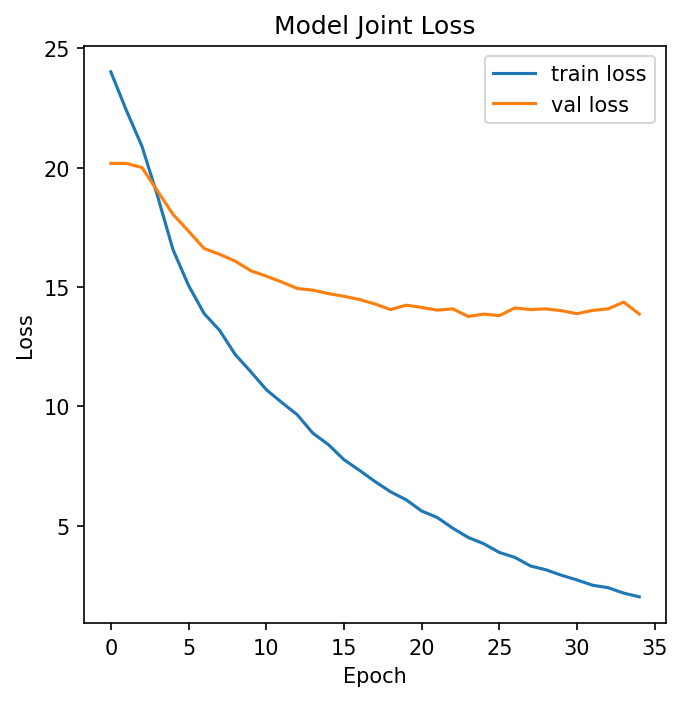

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=150)

# losses
plt.plot(train_losses, label='train loss')
plt.plot(dev_losses, label='val loss')
plt.title('Model Joint Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'CNN_multi_torch_{model_name}_joint_loss.png')

plt.show()

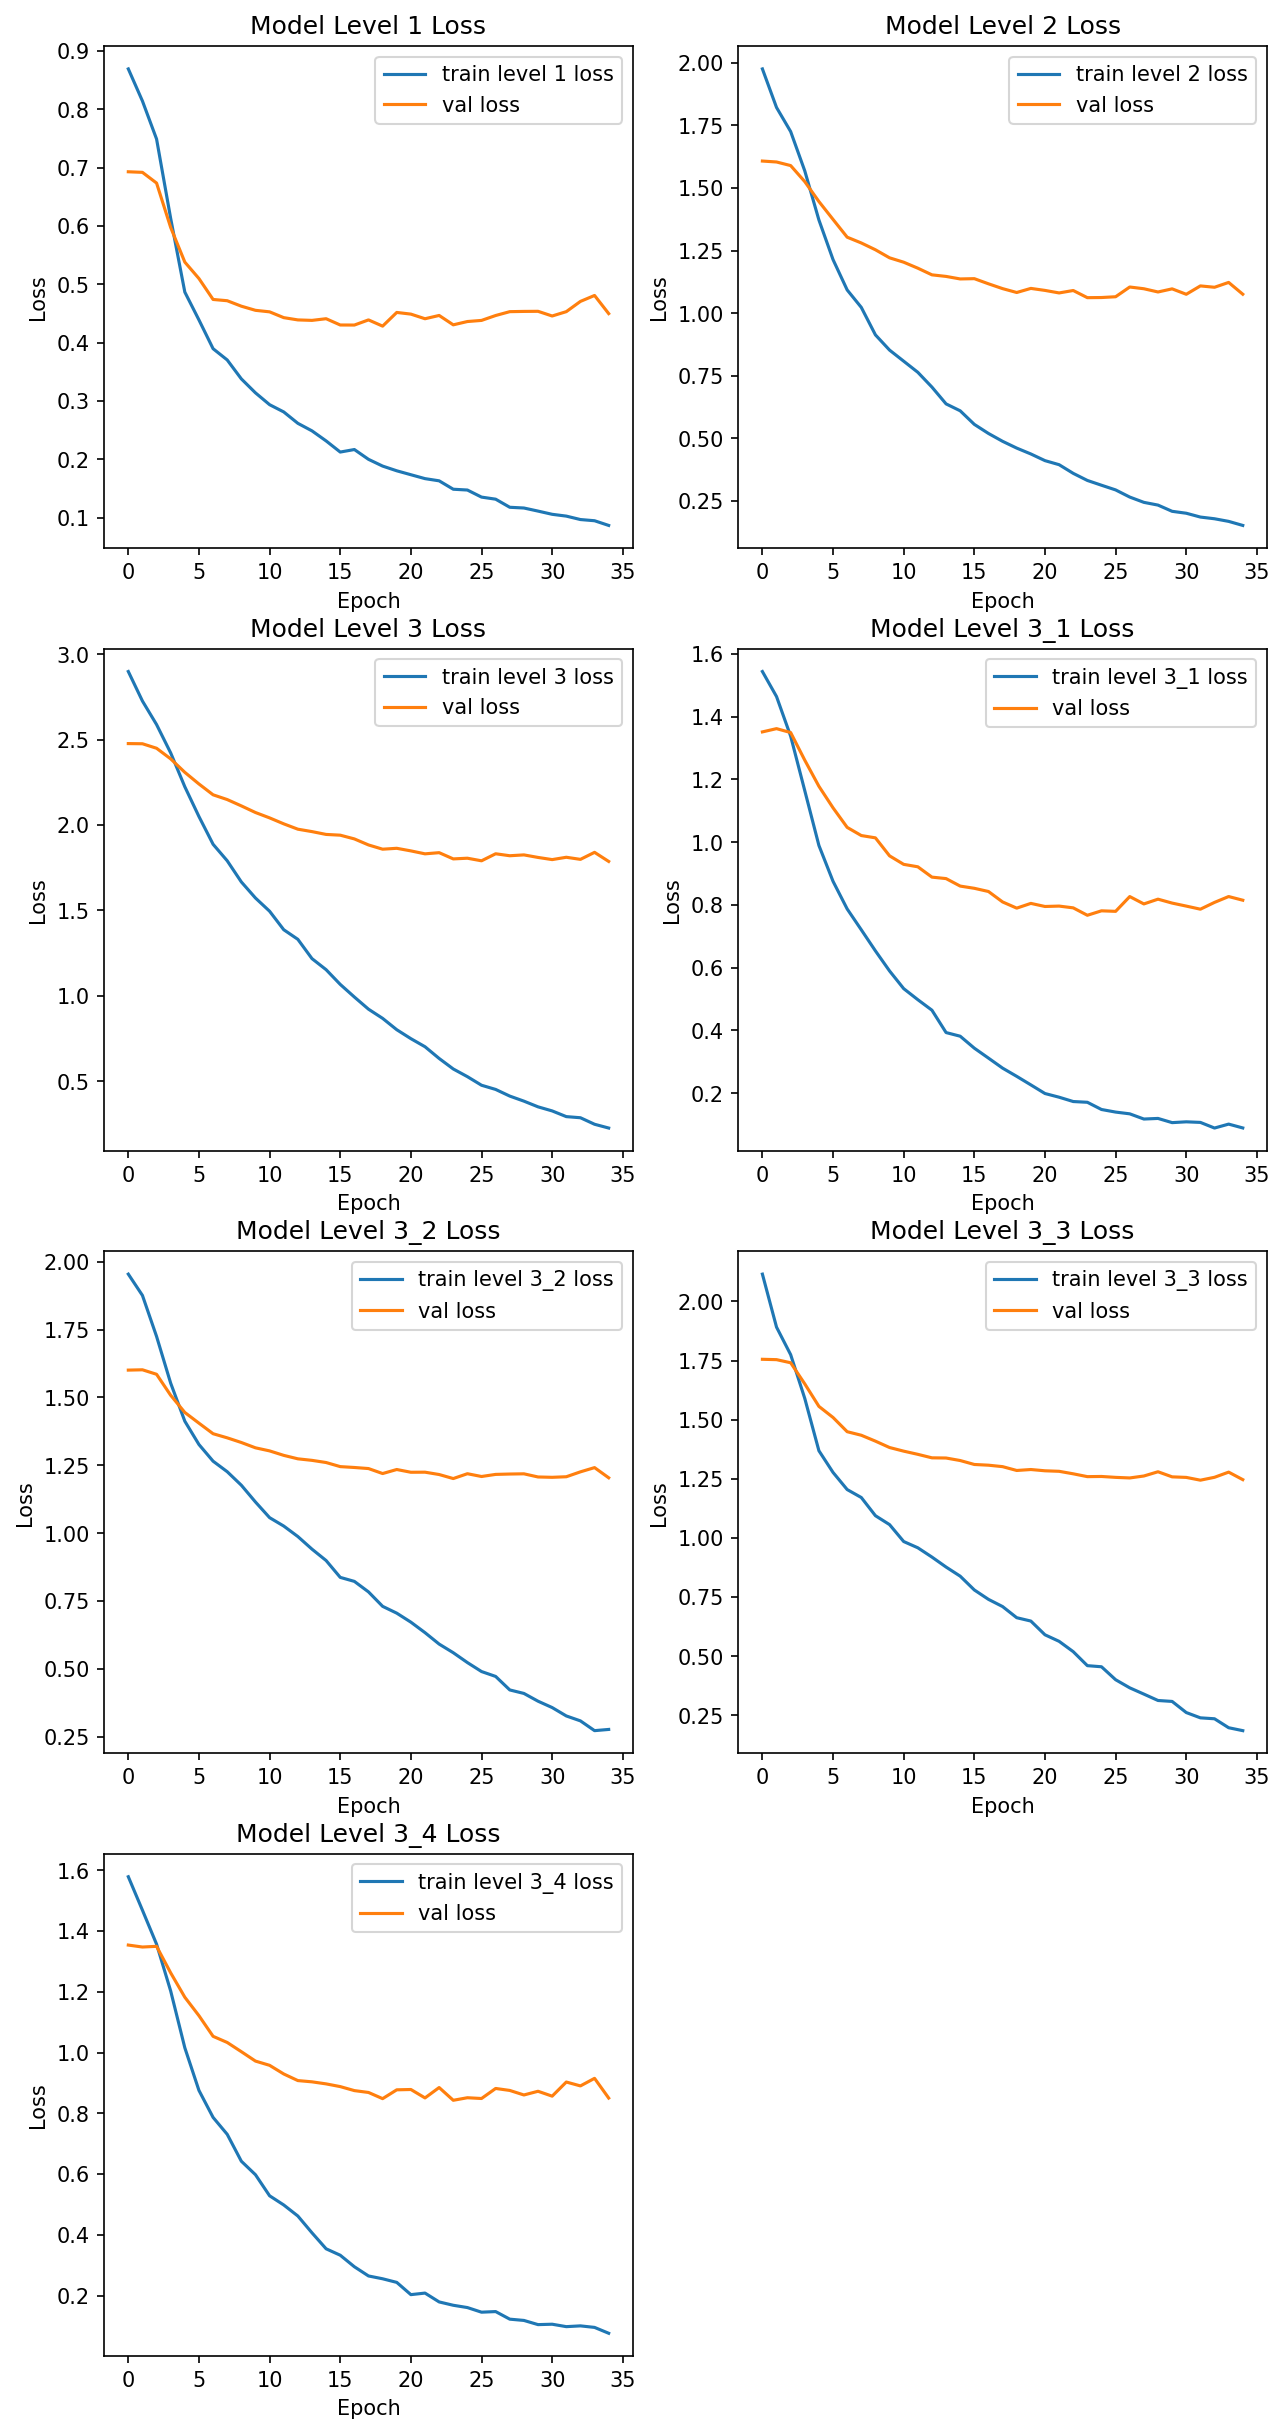

In [27]:
plt.figure(figsize=(10, 20), dpi=150)

# multi losses
for i in range(len(LEVELS)):
    plt.subplot(4, 2, i+1)
    plt.plot([loss[i] for loss in train_multi_losses], label=f'train level {LEVELS[i]} loss')
    plt.plot([loss[i] for loss in dev_multi_losses], label='val loss')
    plt.title(f'Model Level {LEVELS[i]} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

plt.savefig(f'CNN_multi_torch_{model_name}_multi_loss.png')

plt.show()

## **Predict**

In [28]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [29]:
test_preds = [[], [], [], [], [], [], []]

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        logits = model(batch[0].to(device))
        
        for i in range(len(LEVELS)):
            test_preds[i] += torch.argmax(logits[i], dim=1).tolist()
#         print('============ \n')
            
test_preds = torch.tensor(test_preds)
test_preds.shape

100%|██████████| 167/167 [00:08<00:00, 19.11it/s]


torch.Size([7, 4000])

In [30]:
for i in range(len(LEVELS)):
    test[f'pred_{LEVELS[i]}'] = [idx_to_label(idx, i+1) for idx in test_preds[i]]

test.to_csv(f'./{model_name}_test_preds.csv', index=False)
test.head()

,rewire_id,text,label_1,label_2,label_3,label_3_1,label_3_2,label_3_3,label_3_4,tokens,pred_1,pred_2,pred_3,pred_3_1,pred_3_2,pred_3_3,pred_3_4
0,sexism2022_english-9019,"This year, Justin Timberlake should perform in...",not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,"this year , justin timberlake should perform i...",not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist
1,sexism2022_english-8150,"Osaka won youth beat old age, 20 vs 37. Serena...",sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,...",other,other,"3.1 casual use of gendered slurs, profanities,...",other,"osaka won youth beat old age , 20 vs 37 . sere...",sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,...",other,other,"3.1 casual use of gendered slurs, profanities,...",other
2,sexism2022_english-18136,Yeah the only way a man can satisfy those wome...,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm,1.2 incitement and encouragement of harm,other,other,other,yeah the only way a man can satisfy those wome...,sexist,"1. threats, plans to harm and incitement",1.1 threats of harm,1.1 threats of harm,other,other,other
3,sexism2022_english-2602,Young girl 'passed around' to sleep with 100 m...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,young girl ' passed around ' to sleep with 100...,not sexist,4. prejudiced discussions,4.1 supporting mistreatment of individual women,not sexist,not sexist,not sexist,4.1 supporting mistreatment of individual women
4,sexism2022_english-1479,You are an inspiration brother. I follow you o...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,you are an inspiration brother . i follow you ...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist


In [31]:
def get_report(preds, labels):
    reports = []
    for i in range(len(LEVELS)):
        print(f'Level {LEVELS[i]}')
        # print('Labels:', labels[i].shape, 'Preds:', preds[i].shape)
        reports.append(classification_report(labels[i], preds[i], target_names=ALL_LABELS[i], digits=4, output_dict=True))
        print(classification_report(labels[i], preds[i], target_names=ALL_LABELS[i], digits=4))
    return reports

test_reports = get_report(test_preds, y_tests.T)
# print(test_reports, sep='\n')

Level 1
              precision    recall  f1-score   support

  not sexist     0.9207    0.8894    0.9048      3030
      sexist     0.6878    0.7608    0.7225       970

    accuracy                         0.8582      4000
   macro avg     0.8043    0.8251    0.8136      4000
weighted avg     0.8642    0.8582    0.8606      4000

Level 2
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     0.3672    0.5281    0.4332        89
                           2. derogation     0.4293    0.5352    0.4765       454
                            3. animosity     0.3753    0.4835    0.4226       333
               4. prejudiced discussions     0.2596    0.2872    0.2727        94
                              not sexist     0.9326    0.8535    0.8913      3030

                                accuracy                         0.7660      4000
                               macro avg     0.4728    0.5375    0.4992      4000